# Using SCProcessing Package for GSE144236 train test split.
- Making a train split column
- Cleaning metadata
- Adding numeric cluster labels

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
from SCProcessing import TrainSplit
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [ ]:
adata = sc.read_h5ad('~/GSE144236/GSE144236_qc_hvg_anno_5k_raw.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 47021 × 5000
    obs: 'nFeature_RNA', 'nCount_RNA', 'barcodes', 'patient', 'tum.norm', 'celltypes', 'celltypes_lvl2', 'celltypes_lvl3', 'percent_mito', 'RNA_snn_res.0.2', 'RNA_snn_res.0.4', 'RNA_snn_res.0.6', 'RNA_snn_res.0.8', 'RNA_snn_res.1', 'seurat_clusters', 'kmeans_14'
    var: 'n_cells', 'percent_mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'
    obsp: 'distances'

In [5]:
# adata.obs['cluster'] = pd.Categorical(adata.obs['kmeans_14'])
adata.obs['RNA_snn_res.0.2'] = pd.Categorical(adata.obs['RNA_snn_res.0.2'])
adata.obs['RNA_snn_res.0.4'] = pd.Categorical(adata.obs['RNA_snn_res.0.4'])

There is a lot of extra metadata that is redundant so I will remove.

In [6]:
adata.obs = adata.obs.drop(columns=['RNA_snn_res.0.6', 'RNA_snn_res.0.8', 'RNA_snn_res.1', 'seurat_clusters'])

#### Lets quickly visualize what the data looks like

... storing 'patient' as categorical
... storing 'tum.norm' as categorical
... storing 'celltypes' as categorical
... storing 'celltypes_lvl2' as categorical
... storing 'celltypes_lvl3' as categorical


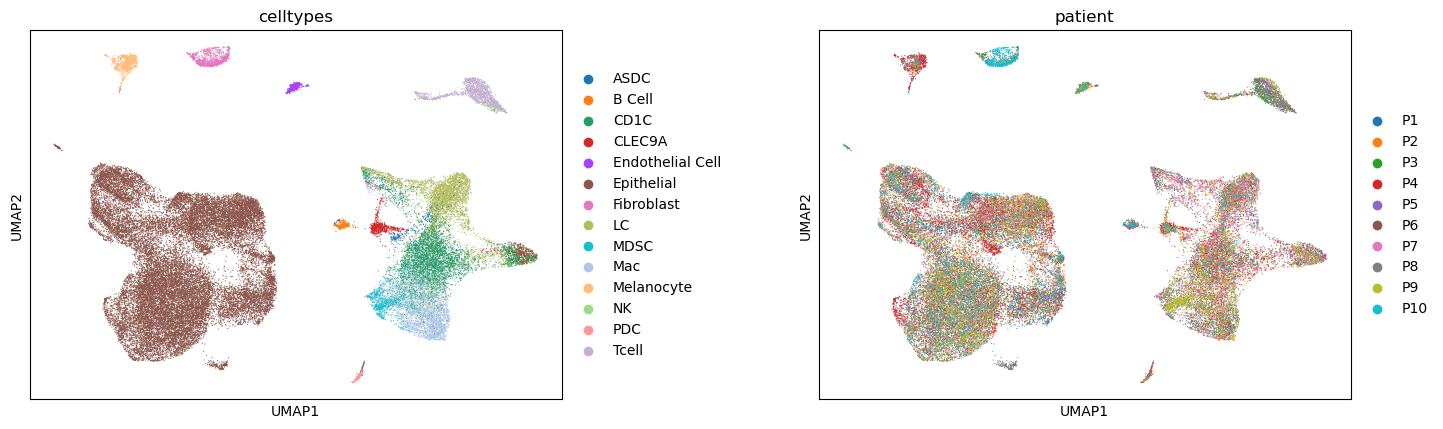

In [7]:
sc.pl.umap(adata, color=['celltypes', 'patient'], wspace=0.35)

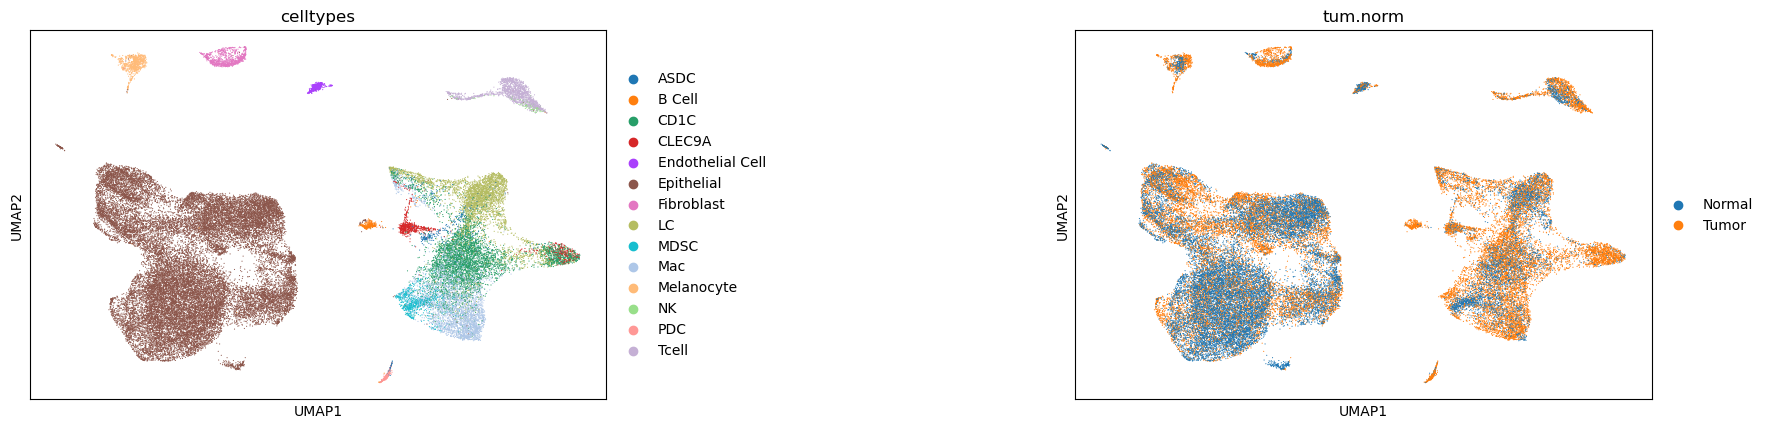

In [8]:
sc.pl.umap(adata, color=['celltypes', 'tum.norm'], wspace=0.65)

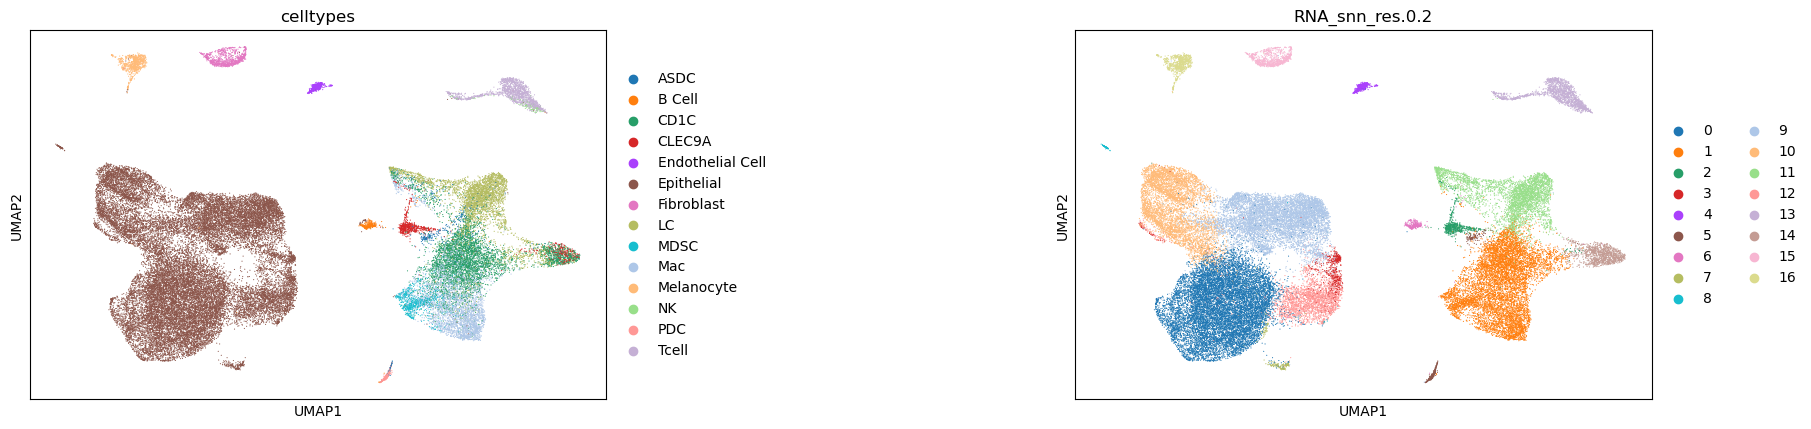

In [9]:
sc.pl.umap(adata, color=['celltypes', 'RNA_snn_res.0.2'], wspace=0.65)

#### Prep for N-ACT

- Create encoded version of 'celltypes' column
- Generate a train/test split of the data (80/20)

In [10]:
encoder_celltype = LabelEncoder()
encoder_celltype.fit(adata.obs['celltypes'])

LabelEncoder()

In [11]:
adata.obs['encoded_celltypes']= encoder_celltype.transform(adata.obs['celltypes']).tolist()

In [12]:
adata.X

<47021x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 25262724 stored elements in Compressed Sparse Row format>

Create a column labeled 'cluster' for SCProcessing to create a balanced split

In [13]:
adata.obs['cluster'] = adata.obs['encoded_celltypes'].tolist()

In [14]:
adata.obs['cluster'].value_counts()

5     28785
2      4913
7      3802
9      3185
13     1624
6       882
3       865
10      796
8       723
4       452
0       345
1       256
12      254
11      139
Name: cluster, dtype: int64

In [15]:
print(f'80%: {47000 * 0.8}')
print(f'20%: {47000 * 0.2}')

80%: 37600.0
20%: 9400.0


In [20]:
obj = TrainSplit(adata, 37600, 0, 9400, balancedSplit=True)

In [21]:
obj.Split()

==> Splitting:
GOT HERE
==> Saving cluster ratios:
    -> Number of clusters: 14
-><- Saved cluster ratios to object attributes
-><- Splitting done
Splitting took 0.37526917457580566 seconds


In [22]:
adata.obs['split'].value_counts()

train    37621
test      9400
valid        0
Name: split, dtype: int64

In [23]:
adata[adata.obs['split'] == 'test'].obs['cluster'].value_counts()

5     5725
2     1022
7      777
9      629
13     310
6      173
3      164
8      148
10     140
4       93
0       77
1       59
12      51
11      32
Name: cluster, dtype: int64

#### Check dtype for sparse matrix (prefer float 32)

In [24]:
adata.X

<47021x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 25262724 stored elements in Compressed Sparse Row format>

In [25]:
adata.raw.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

Convert to float 32

In [26]:
from scipy.sparse import csr_matrix
adata.X = csr_matrix(adata.X, dtype=np.float32)

In [27]:
raw_mat = adata.raw.X

In [28]:
# raw_mat = raw_mat.todense()

In [29]:
raw_mat = np.array(raw_mat, dtype=np.float32)

In [30]:
raw_mat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [31]:
import anndata
adata2 = anndata.AnnData(raw_mat)
adata2.X = csr_matrix(adata2.X, dtype=np.float32)

In [32]:
adata.raw = adata2

In [33]:
adata.raw.X.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [34]:
adata.write_h5ad('~/GSE144236/GSE144236_qc_hvg_anno_5k_raw_train_split.h5ad')